In [1]:
import os 

cwd = os.getcwd()

print("Current working directory: {0}".format(cwd))

print ("os.getcwd() returns an object of type {0}".format(type(cwd)))

#copy the filepath 
os.chdir("C:/Users/eotie/Downloads")

Current working directory: C:\Users\eotie
os.getcwd() returns an object of type <class 'str'>


C:\Users\eotie\AppData\Local\Temp\ipykernel_30400\411221736.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time = pd.to_datetime(date_time)
C:\Users\eotie\AppData\Local\Temp\ipykernel_30400\411221736.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])


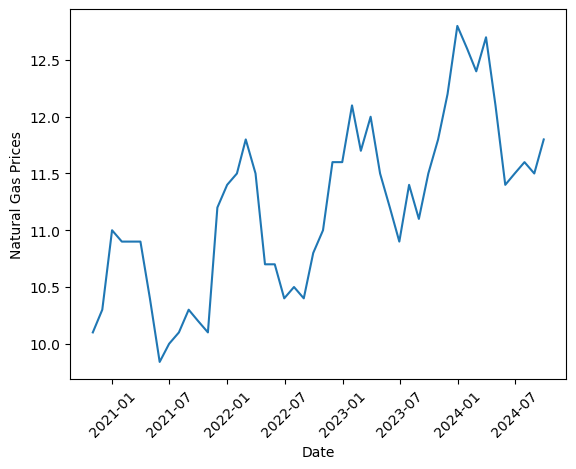

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

date_time =["10-2020", "11-2020","12-2020"]
date_time = pd.to_datetime(date_time)
data =[1,2,3]

df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

# plot prices against dates 
fig, ax = plt.subplots()
ax.plot(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

In [3]:
#From the plot we can see that prices have a natural one year frequency, with prices, which are trending upwards, peaking in the winter months and dipping in the summer months.
#We do a linear regeression to model the trend and a fourier series(fit a sin function) to model the seasonality.

#First we create variables that represent the start date and end date to make it easier to interpolate later on.
start_date = date(2020, 10, 31)
end_date = date(2024, 9, 30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1

days_from_start = [(day - start_date).days for day in months]



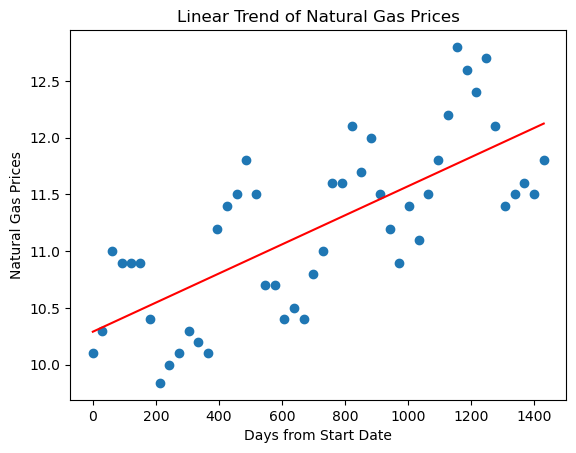

Slope: 0.001282373598760221, Intercept: 10.29104112595228


In [4]:
#simple regression for the trend will fit into a model y=Ax+B. the estimator for A is given by: \hat{A} = \frac{\sum(x_i-\bar{x})(y_i-\bar{y})}{\sum(x_i-\bar{x})^2} 
# and the estimator for B is given by: \hat{B} = \bar{y} - \hat{A}\bar{x}
#where \bar{x} is the mean of x values and \bar{y} is the mean of y values.
def simple_regression (x,y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x-xbar)*(y-ybar))/np.sum((x-xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

#plot linear trend 
plt.plot (time, prices, 'o', label='Data')
plt.plot (time, slope*time + intercept, 'r-', label='Linear Trend')
plt.xlabel('Days from Start Date')
plt.ylabel('Natural Gas Prices')
plt.title('Linear Trend of Natural Gas Prices')
plt.show()
print ("Slope: {0}, Intercept: {1}".format(slope, intercept))


Text(0.5, 1.0, 'Smoothed Estimate of Monthly Natural Gas Prices')

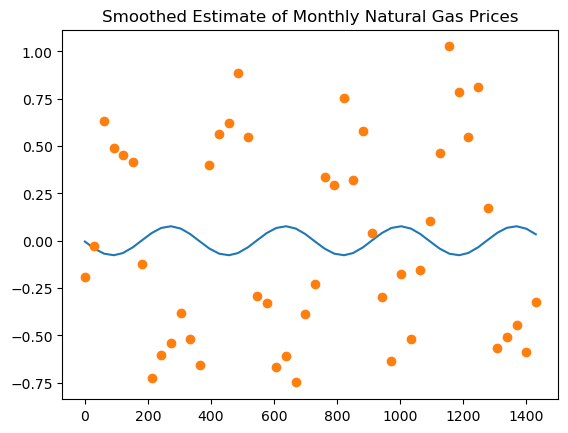

In [5]:
# From this we can see the linear trend has been captured. Now to fit the intra-year variation.
#Given that natural gas is used more in winter, and less in summer, we can guess the frequency of price movements to be about a year, or 12 months. 
#Therefore we have a model Y=Asin(kt+z) with a known frequency. Rewriting Y=Acos(z)sin(kt)+Asin(z)cos(kt), we can use billinear regression to estimate the coefficients Acos(z) and Asin(z).

sin_prices = prices - (slope*time + intercept)
sin_time  = np.sin(time * 2 * np.pi /(365) )
cos_time  = np.cos(time * 2 * np.pi /(365) )

def bilinear_regression (x1, x2, y):
    #Billinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return slope1, slope2

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

#We now recoevr the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z =tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

#Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot (time, sin_prices, 'o', label='Data')
plt.title('Smoothed Estimate of Monthly Natural Gas Prices')



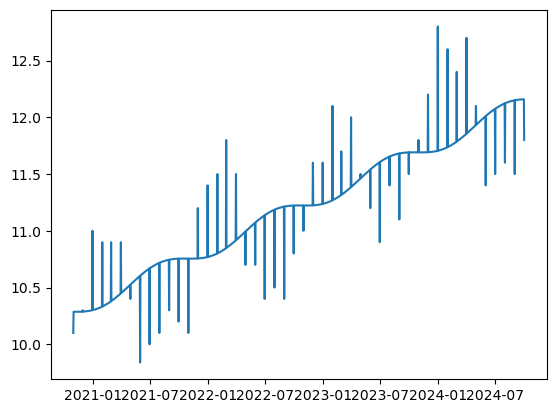

In [6]:
#Define the interpolation/extrapolation function
def interpolate (date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        #Exact match found in the data 
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + slope * days + intercept
    
# Create a range of continuous dates from start date to end date
continuous_dates= pd.date_range (start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate of the full dataset using the interpolation function
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')


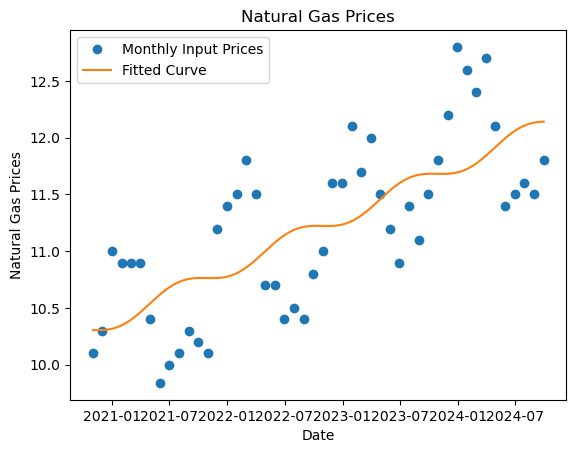

In [7]:
#Fix the monthly input prices to the sine curve 
x= np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fitted Curve')

plt.xlabel('Date')
plt.ylabel('Natural Gas Prices')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()
